In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline

In [17]:
class Value():
    def __init__(self,data,operation=None,_children =(),label=None):
        self.data = data
        self.grad = 0.0
        self.label = label if label is not None else str(data)
        self.operation = operation
        self._backpass = lambda: None
        self.children = set(_children)
        
    def __repr__(self):
        return f"Value:{self.data},label:{self.label}"
        
    def __add__(self,other):
        
        if isinstance(other,(int,float)):
            other = Value(other)
            
        v = Value(self.data+other.data,"+",(self,other))
        # v.label = f"{self.label}{other.label}"
        def backpass():
            self.grad += 1.0*v.grad
            other.grad += 1.0*v.grad
            
        v._backpass = backpass
        return v
        
    def __mul__(self,other):
        
        if isinstance(other,(int,float)):
            other = Value(other)
            
        v = Value(self.data*other.data,"*",(self,other))
        # v.label = f"{self.label}{other.label}"
        def backpass():
            self.grad += other.data*v.grad
            other.grad += self.data*v.grad
            
        v._backpass = backpass
        return v

    def __pow__(self,other):
        assert isinstance(other,(int,float)),"Only int or float"
        v = Value(self.data**other,"pow",(self,))
        def backpass():
            self.grad += other.data*(self.data**(other.data - 1)) * v.grad
        v._backpass = backpass
        return v
    def __rmul__(self,other):  
        return self*other

    def __radd__(self,other):
        return self+other
        
    def __truediv__(self,other):
        if isinstance(other,(int,float)):
            other = Value(other)
        return self * (other.data**-1)
        
    def __rtruediv__(self,other):
        if isinstance(other,(int,float)):
            other = Value(other)
        return ((self.data)**-1) * other 
        
    def tanh(self):
        tanh = (np.exp(2*self.data) - 1)/(np.exp(2*self.data) +1)
        v = Value(tanh,"tanh",(self,))
        
        def backpass():
            self.grad += (1 - (tanh**2)) * v.grad
        
        v._backpass = backpass
        return v
            
    def backpass(self):
        def topological_sort(root,sorted_graph):            
            
            # for x in root.children:
            #     if x not in sorted_graph:
            #         sorted_graph.append(x)
            
            if root not in sorted_graph:
                for x in root.children:
                    topological_sort(x,sorted_graph)
                
                
                sorted_graph.append(root)
            return sorted_graph
        
        topo_list = topological_sort(self,[])
        self.grad = 1
        for x in topo_list[::-1]:
            x._backpass()

In [18]:
a = Value(1.0,label="a")
a1 = Value(1.5,label="a1")
b = Value(1.75,label="b")
c = b * a1;c.label = "c";
d = Value(1.25,label="d")
e = a * b;e.label = "e";
f = c + e;f.label = "f";
g = d * f;g.label = "g";
o = g.tanh();o.label = "l"

In [19]:
import graphviz as graph 

In [20]:
def draw_nn(root: Value,dot):
    dot.node(root.label,label = "{ %s | data %.4f | grad %.4f }" % (root.label, root.data, root.grad), shape='record')
    
    if root.operation != None:
        dot.node(root.operation+root.label,label =root.operation)
        dot.edge(root.operation+root.label,root.label)
    if root.children != None:
        for x in root.children:
            dot.node(x.label)
            dot.edge(x.label,root.operation+root.label)
            draw_nn(x,dot)
    return dot
    

In [21]:
o.backpass()

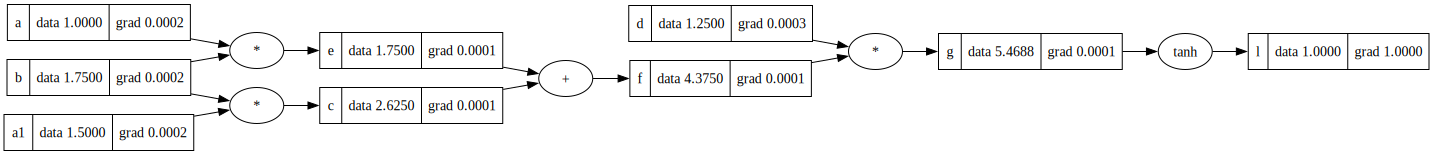

In [22]:
dot = graph.Digraph("nn",graph_attr={'rankdir': 'LR'},node_attr={"orientation":"270"})
draw_nn(o,dot)

In [1]:
class Neuron:
    def __init__(self,nin):
        self.W = [Value(x) for x in np.random.normal(size=nin)]
        self.b = Value(np.random.normal(size=1)[0],label="bias")

    def __call__(self,X):
        out = sum((w*x for w,x in zip(self.W,X)),self.b)
        out = out.tanh()
        return out

    def parameters(self):
        return self.W + [self.b]

In [5]:
class Layer:
    def __init__(self,nin,nout):
        self.neurons = [Neuron(nin,layer=x) for x in range(nout)]
        
    def __call__(self,X = []):
        layer_out = []
        for x,n in zip(X,self.neurons):
            out = n(x)
            layer_out.append(out)        

        return layer_out
        
    def parameters(self):
        layer_parameters = []
        for x in self.neurons:
            layer_parameters.append(n.parameters())
        return layer_parameters

In [3]:
class nn:
    def __init__(self,nin,layerspec,out):
        self.nin = nin
        self.layerspec = layerspec
        self.out = out
        

In [ ]:
X = [[1.1,2,3],[4,5,6],[7,8,9]]
l = Layer()